In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [5]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [6]:
dataset_name = "W14_only"

In [8]:
data_subfolder = BES_data_folder + dataset_name + os.sep
dataset_filename = "BES2017_W14_v0.3.dta"
BES_Panel  = pd.read_stata(data_subfolder + dataset_filename)
print("BES_Panel", BES_Panel.shape )

BES_Panel (31063, 519)


In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (68625, 5150)
var_type (5150, 13)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)
Wall time: 11.6 s


In [6]:
## Conservative voters

In [7]:
# [x for x in BES_Panel.columns if "ptv" in x]

In [8]:
# 'profile_past_vote_2005'
# 'profile_past_vote_2010'
# 'profile_past_vote_2015'
# 'generalElectionVoteW13'

In [9]:
# 'ptvLabW13'
# BES_Panel['profile_past_vote_2005']
# Labour Party

In [10]:
ConservativeNow = BES_Panel['generalElectionVoteW13']=="Conservative"
EverLabour = (BES_Panel['profile_past_vote_2015']=="Labour")|(BES_Panel['profile_past_vote_2010']=="Labour Party")|(BES_Panel['profile_past_vote_2005']=="Labour Party")
Labour2015 = BES_Panel['profile_past_vote_2015']=="Labour"
MoreLikelyThanNotPTVLabour = BES_Panel['ptvLabW13'].replace("Don't know",np.nan).cat.codes>5

In [11]:
print( sum(ConservativeNow[Labour2015]) / sum(ConservativeNow) )
print( sum(ConservativeNow[EverLabour]) / sum(ConservativeNow) )
print( sum(ConservativeNow[MoreLikelyThanNotPTVLabour]) / sum(ConservativeNow) )

0.06409915891987605
0.18326693227091634
0.12545374059318282


In [12]:
## Age by values
# Stephen Bush referred to young voters as less inclined to favour redistribution (all things being equal)
# Suspect he's right about "generalised left-right" - but wrong about *redistribution*

In [13]:
# [x for x in BES_reduced_with_na.columns if "lr" in x.lower()]

##BES_Panel
# ageW1,W7/8/9/11/12/13
# Age
# ageGroup
# 'lr_scaleW13'
# lr(1-5)W13

##BES_reduced_with_na
# 'lr5W13__Strongly agree'
# 'ageGroup__66+'

In [14]:
output_subfolder = BES_output_folder +  os.sep + "randomFunPlots"
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [15]:
Treatment = "Age_by_values"
output_sub_subfolder = output_subfolder + os.sep + Treatment
if not os.path.exists( output_sub_subfolder ):
    os.makedirs( output_sub_subfolder )

In [16]:
# al_vars = [x for x in BES_reduced_with_na.columns if re.match("al\dW13",x)]
# df = pd.concat( [ BES_Panel["ageGroup"], BES_reduced_with_na[al_vars] ] ,axis=1)
# df = pd.melt(df, id_vars = ["ageGroup"], value_vars = al_vars)
# df.columns = ['ageGroup', 'al_variable', 'value']
# df = df.dropna()

# plt.figure(figsize=(12,8))
# sns.barplot(x="ageGroup",hue="al_variable",y="value",data=df);
# # plt.ylim(2,3.5);
# plt.savefig(output_sub_subfolder + "something_about_redistribution" + ".png", bbox_inches='tight')

In [17]:
# lr_vars = [x for x in BES_reduced_with_na.columns if re.match("lr\dW1W2W3W4W5",x)] # lr1W1W2W3W4W5
# df = pd.concat( [ BES_Panel["ageGroup"], BES_reduced_with_na[lr_vars] ] ,axis=1)
# df = pd.melt(df, id_vars = ["ageGroup"], value_vars = lr_vars)
# df.columns = ['ageGroup', 'lr_variable', 'value']
# df = df.dropna()

In [18]:
# plt.figure(figsize=(12,8))
# sns.barplot(x="ageGroup",hue="lr_variable",y="value",data=df);
# # plt.ylim(2,3.5);

In [19]:
# Better names for lr variables

# lr1
# Government should redistribute income from the better off to those who are less well off
# lr2
# Big business takes advantage of ordinary people
# lr3
# Ordinary working people do not get their fair share of the nation’s wealth
# lr4
# There is one law for the rich and one for the poor
# lr5
# Management will always try to get the better of employees if it gets the chance



In [20]:
from textwrap import wrap

In [21]:
lr_text = ["Government should redistribute income from the better off to those who are less well off",
"Big business takes advantage of ordinary people",
"Ordinary working people do not get their fair share of the nation’s wealth",
"There is one law for the rich and one for the poor",
"Management will always try to get the better of employees if it gets the chance",
"Derived Economic Right-Left Scale (average of above 5 answers)"]
lr_text = [ '\n'.join(wrap(l, 20)) for l in lr_text]
lr_reorder = [0,2,3,1,4,5]

x_var = 'ageGroup'
y_var = 'mean answer'
split_var = 'lr_variable'

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


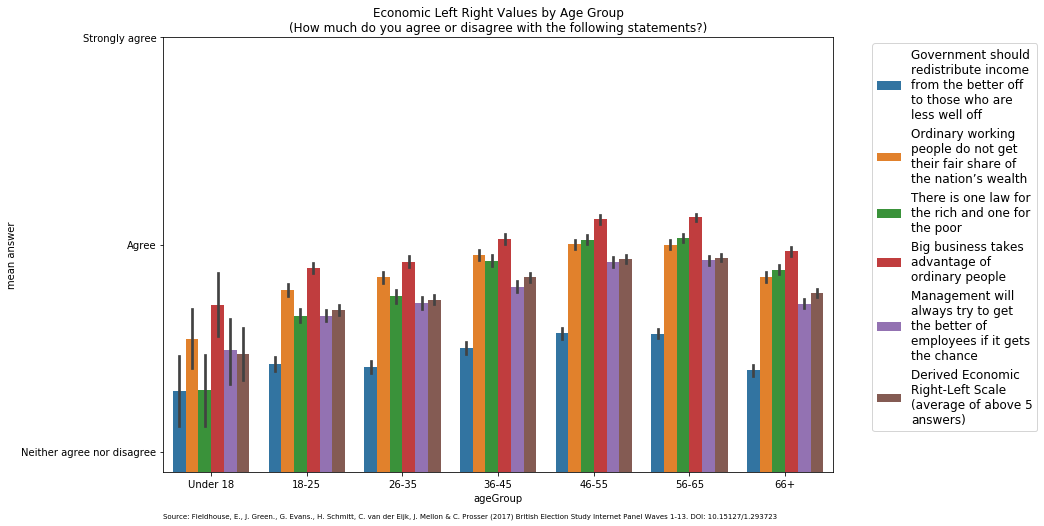

In [22]:
lr_vars = sorted([x for x in BES_reduced_with_na.columns if re.match("(lr\d|lr_scale)W1W2W3W4W5",x)])
df = pd.concat( [ BES_Panel[x_var], BES_reduced_with_na[lr_vars] ] ,axis=1)
df[lr_vars[5]] = (20-df[lr_vars[5]])/5


df.columns = [x_var]+lr_text

df = pd.melt(df, id_vars = [x_var], value_vars = [ lr_text[i] for i in lr_reorder])

df.columns = [x_var, split_var, y_var]
# df = df.dropna()
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, x=x_var, hue=split_var, y=y_var, data=df);


# labels = [ '\n'.join(wrap(l, 20)) for l in lr_text]
ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);


plt.ylim(1.9,4);
plt.yticks([2,3,4], ["Neither agree nor disagree","Agree","Strongly agree"]);
plt.title("Economic Left Right Values by Age Group\n(How much do you agree or disagree with the following statements?)")

dataset_citation = "Source: " + manifest["Citation"].values[0]

ax.annotate(dataset_citation, (0,0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)            

plt.savefig(output_sub_subfolder + os.sep + "lr_by_ageGroup_absolute" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


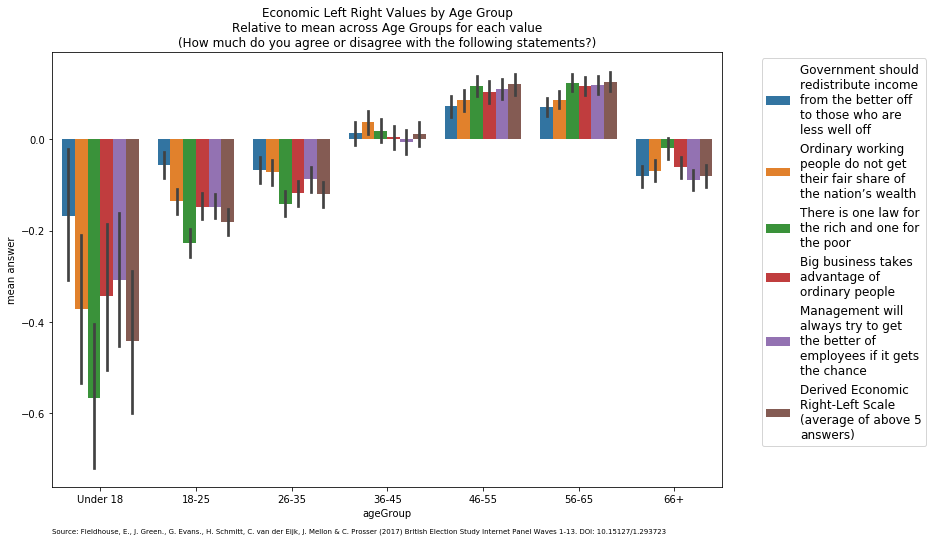

In [23]:
lr_vars = sorted([x for x in BES_reduced_with_na.columns if re.match("(lr\d|lr_scale)W1W2W3W4W5",x)])
df = pd.concat( [ BES_Panel[x_var], BES_reduced_with_na[lr_vars] ] ,axis=1)
df[lr_vars[5]] = (20-df[lr_vars[5]])/5
# df

df.columns = [x_var]+lr_text
df[lr_text] = ( df[lr_text]-df[lr_text].mean() ) / df[lr_text].std()

df = pd.melt(df, id_vars = [x_var], value_vars = [ lr_text[i] for i in lr_reorder])

df.columns = [x_var, split_var, y_var]
# df = df.dropna()
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, x=x_var, hue=split_var, y=y_var, data=df);


# labels = [ '\n'.join(wrap(l, 20)) for l in lr_text]
ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);
plt.title("Economic Left Right Values by Age Group\nRelative to mean across Age Groups for each value\n(How much do you agree or disagree with the following statements?)")
dataset_citation = "Source: " + manifest["Citation"].values[0]

ax.annotate(dataset_citation, (0,0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  
# plt.ylim(1.9,4);
# plt.yticks([2,3,4], ["Neither agree nor disagree","Agree","Strongly agree"]);
plt.savefig(output_sub_subfolder + os.sep + "lr_by_ageGroup_relative" + ".png", bbox_inches='tight')


In [24]:
al_text = ["Young people today don’t have enough respect for traditional British values",
"For some crimes, the death penalty is the most appropriate sentence",
"Schools should teach children to obey authority",
"Censorship of films and magazines is necessary to uphold moral standards",
"People who break the law should be given stiffer sentences",
"Derived Social Liberal-Authoritarian Scale (average of above 5 answers)"]

al_text = [ '\n'.join(wrap(l, 20)) for l in al_text]
al_reorder = [0,1,2,3,4,5]

x_var = 'ageGroup'
y_var = 'mean answer'
split_var = 'al_variable'

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


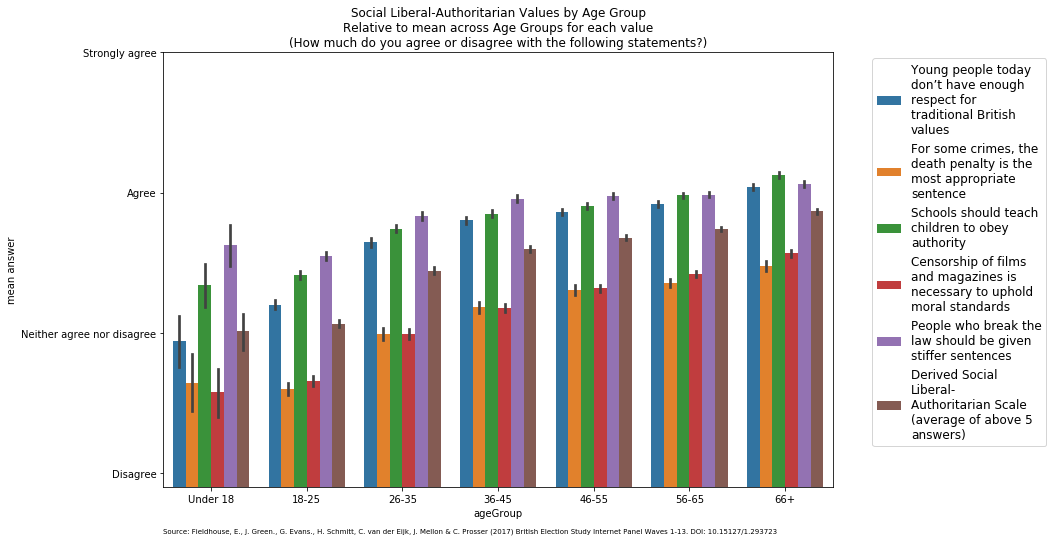

In [25]:
al_vars = sorted([x for x in BES_reduced_with_na.columns if re.match("(al\d|al_scale)W1W2W3W4W5",x)])
df = pd.concat( [ BES_Panel[x_var], BES_reduced_with_na[al_vars] ] ,axis=1)
df[al_vars[5]] = df[al_vars[5]]/5


df.columns = [x_var]+al_text

df = pd.melt(df, id_vars = [x_var], value_vars = [ al_text[i] for i in al_reorder])

df.columns = [x_var, split_var, y_var]
# df = df.dropna()
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, x=x_var, hue=split_var, y=y_var, data=df);


# labels = [ '\n'.join(wrap(l, 20)) for l in lr_text]
ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

plt.title("Social Liberal-Authoritarian Values by Age Group\nRelative to mean across Age Groups for each value\n(How much do you agree or disagree with the following statements?)")
dataset_citation = "Source: " + manifest["Citation"].values[0]

ax.annotate(dataset_citation, (0,0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  
plt.ylim(.9,3.5);
plt.yticks([1,2,3,4], ["Disagree","Neither agree nor disagree","Agree","Strongly agree"]);
plt.savefig(output_sub_subfolder + os.sep +"al_by_ageGroup_absolute" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


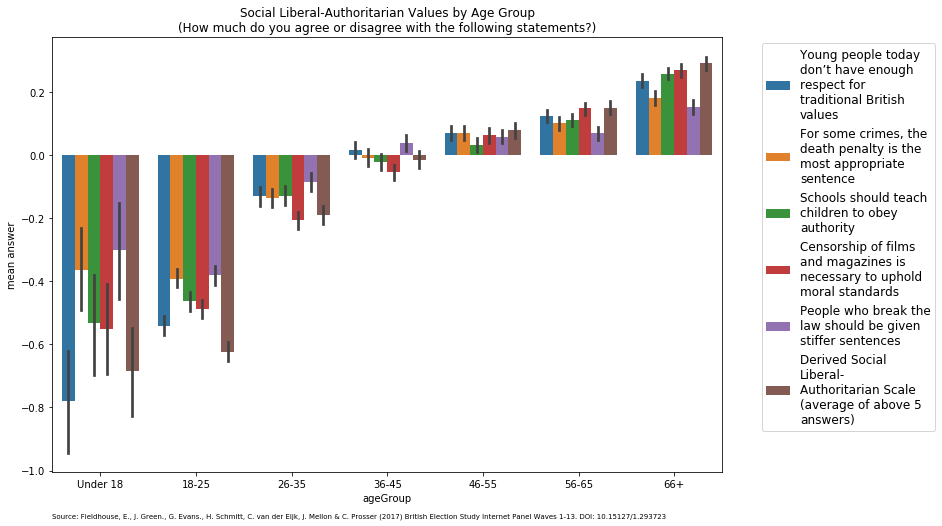

In [26]:
al_vars = sorted([x for x in BES_reduced_with_na.columns if re.match("(al\d|al_scale)W1W2W3W4W5",x)])
df = pd.concat( [ BES_Panel[x_var], BES_reduced_with_na[al_vars] ] ,axis=1)
df[al_vars[5]] = df[al_vars[5]]/5


df.columns = [x_var]+al_text
df[al_text] = ( df[al_text]-df[al_text].mean() ) / df[al_text].std()

df = pd.melt(df, id_vars = [x_var], value_vars = [ al_text[i] for i in al_reorder])

df.columns = [x_var, split_var, y_var]
# df = df.dropna()
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, x=x_var, hue=split_var, y=y_var, data=df);


# labels = [ '\n'.join(wrap(l, 20)) for l in lr_text]
ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);


plt.title("Social Liberal-Authoritarian Values by Age Group\n(How much do you agree or disagree with the following statements?)")
dataset_citation = "Source: " + manifest["Citation"].values[0]

ax.annotate(dataset_citation, (0,0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  
# plt.ylim(.9,3.5);
# plt.yticks([1,2,3,4], ["Disagree","Neither agree nor disagree","Agree","Strongly agree"]);
plt.savefig(output_sub_subfolder + os.sep + "al_by_ageGroup_relative" + ".png", bbox_inches='tight')

In [27]:
[ print(lr_text[i]+"\n========================") for i in lr_reorder[0:5]];

Government should
redistribute income
from the better off
to those who are
less well off
Ordinary working
people do not get
their fair share of
the nation’s wealth
There is one law for
the rich and one for
the poor
Big business takes
advantage of
ordinary people
Management will
always try to get
the better of
employees if it gets
the chance


In [28]:
# BES_Panel[[x for x in BES_Panel.columns if re.match("wt",x)]].notnull().sum().sort_values()

In [29]:
## I want to dig into the income distribution by euRefVote

In [31]:
df = BES_Panel[ [x for x in BES_Panel.columns if re.match("euRefVoteW",x)] ].stack().reset_index().drop("level_0",axis=1)

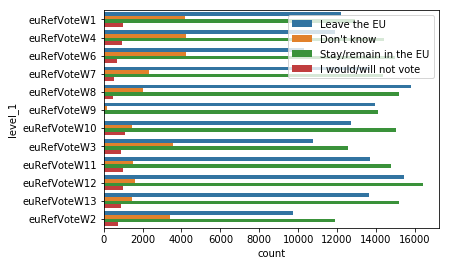

In [32]:
## quick skim of euRefVote over time!


sns.countplot(data=df,y="level_1",hue=0)

In [33]:
# pd.crosstab(BES_Panel["euRefVoteW1"], columns, BES_Panel["wt_full_W1"]

In [34]:
#############################################

# [x for x in BES_Panel.columns if "profile_" in x]

In [35]:
BES_Panel[ [x for x in BES_Panel.columns if "profile_gross" in x] ].notnull().sum()

profile_gross_householdW10    30314
profile_gross_householdW11    30350
profile_gross_householdW12    33708
profile_gross_householdW13    30784
profile_gross_household       57625
profile_gross_personal        57480
dtype: int64

In [36]:
df = BES_Panel[["profile_gross_personal", "profile_eurefvote"]]
df = pd.crosstab(columns = df["profile_gross_personal"], index = df["profile_eurefvote"]).stack().reset_index()
df.columns = ['profile_eurefvote', 'profile_gross_personal', 'percentage']
df

,profile_eurefvote,profile_gross_personal,percentage
0,Stay/remain in the EU,"under Â£5,000 per year",1784
1,Stay/remain in the EU,"Â£5,000 to Â£9,999 per year",1670
2,Stay/remain in the EU,"Â£10,000 to Â£14,999 per year",1986
3,Stay/remain in the EU,"Â£15,000 to Â£19,999 per year",1956
4,Stay/remain in the EU,"Â£20,000 to Â£24,999 per year",1907
5,Stay/remain in the EU,"Â£25,000 to Â£29,999 per year",1547
6,Stay/remain in the EU,"Â£30,000 to Â£34,999 per year",1206
7,Stay/remain in the EU,"Â£35,000 to Â£39,999 per year",877
8,Stay/remain in the EU,"Â£40,000 to Â£44,999 per year",685
9,Stay/remain in the EU,"Â£45,000 to Â£49,999 per year",471


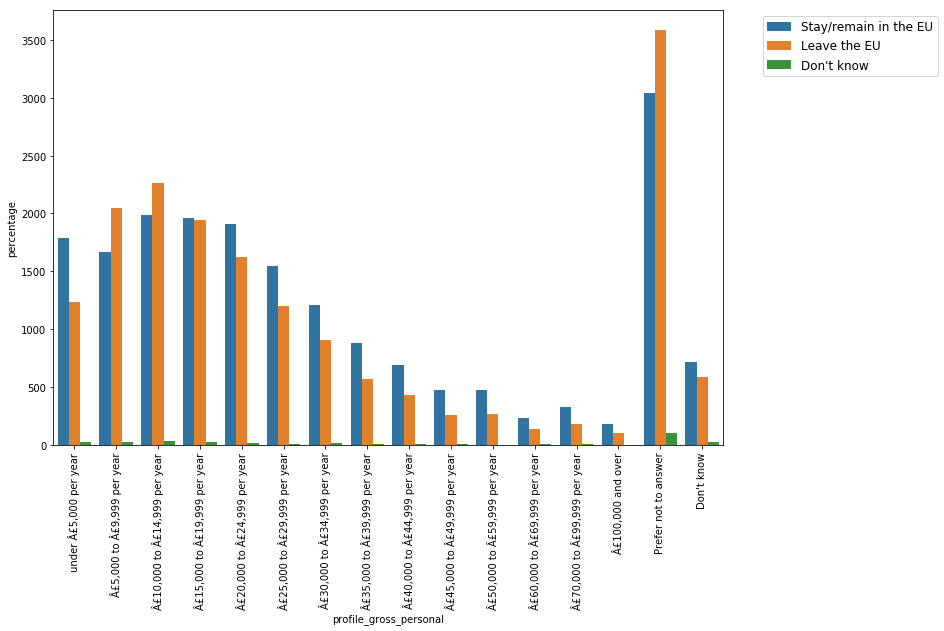

In [37]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x='profile_gross_personal',y='percentage',hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

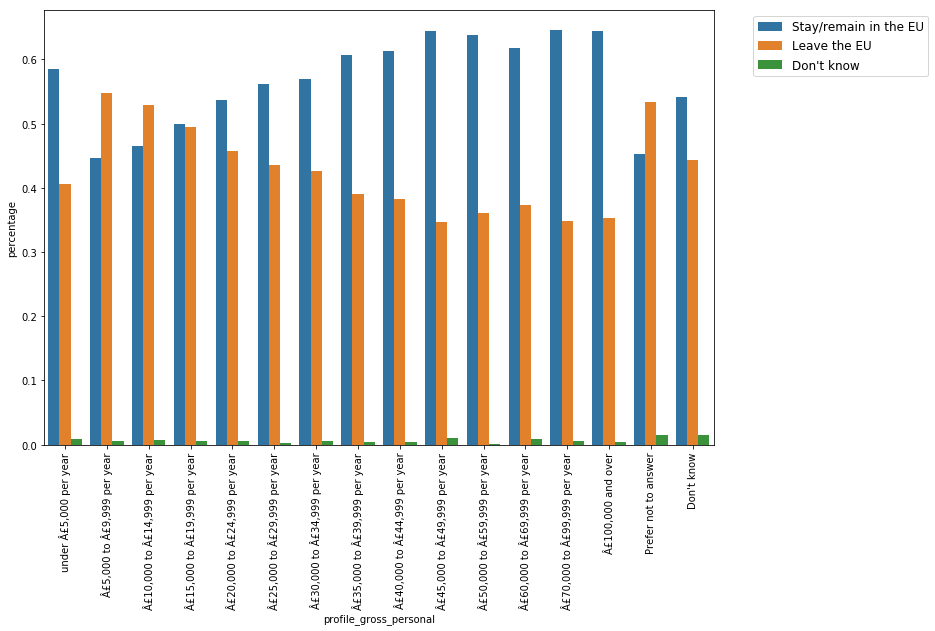

In [38]:
df = BES_Panel[["profile_gross_personal", "profile_eurefvote"]]
df = pd.crosstab(columns = df["profile_gross_personal"], index = df["profile_eurefvote"], normalize='columns').stack().reset_index()
df.columns = ['profile_eurefvote', 'profile_gross_personal', 'percentage']


plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x='profile_gross_personal',y='percentage',hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

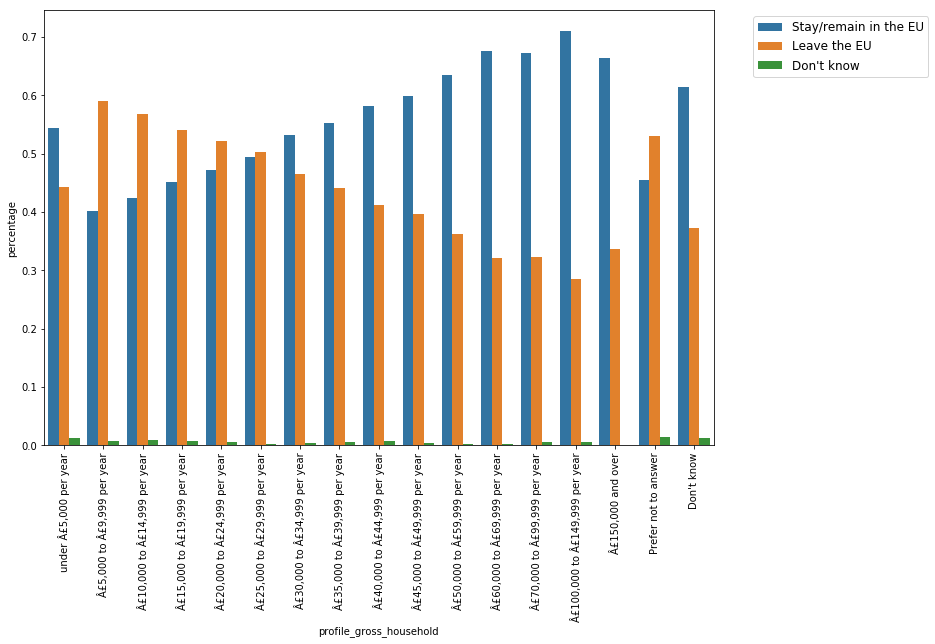

In [39]:
income = "profile_gross_household"
df = BES_Panel[[income, "profile_eurefvote"]]
df = pd.crosstab(columns = df[income], index = df["profile_eurefvote"], normalize='columns').stack().reset_index()
df.columns = ['profile_eurefvote', income, 'percentage']


plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

In [40]:
BES_Panel[[x for x in BES_Panel.columns if re.match("bes\d",x)]].notnull().sum()

bes1aW2    1327
bes2aW2    1350
bes3aW2    1316
bes4aW2    1410
bes4bW2    1410
dtype: int64

In [48]:
[x for x in BES_Panel.columns if re.match("wt",x)]

['wt_core_W3',
 'wt_core_W4',
 'wt_core_W5',
 'wt_core_W6',
 'wt_core_W7',
 'wt_core_W8',
 'wt_core_W9',
 'wt_core_W1',
 'wt_core_W2',
 'wt_full_W3',
 'wt_full_W1W2W3',
 'wt_full_W4',
 'wt_full_W1W2W3W4',
 'wt_full_W5',
 'wt_full_W1W2W3W4W5',
 'wt_full_W4W5',
 'wt_full_W6',
 'wt_full_W1W2W3W4W5W6',
 'wt_full_W4W5W6',
 'wt_full_W4W6',
 'wt_full_W7',
 'wt_full_W8',
 'wt_full_W1W2W3W4W5W6W7W8',
 'wt_full_W7W8',
 'wt_full_W9',
 'wt_full_W1W2W3W4W5W6W7W8W9',
 'wt_full_W7W8W9',
 'wt_full_W10',
 'wt_full_W11',
 'wt_full_W1_W11',
 'wt_full_W1',
 'wt_full_W2',
 'wt_full_W1W2',
 'wt_full_W1W2W3W4W5W6W7',
 'wt_daily_W5',
 'wt_new_W11',
 'wt_new_W6W7',
 'wt_new_W2W6',
 'wt_new_W2W6W7',
 'wt_new_W9_W13',
 'wt_new_W12',
 'wt_daily_W12',
 'wt_new_W13',
 'wt_new_W1_W11',
 'wt_new_W1_W12',
 'wt_new_W1_W13',
 'wt_new_W6_W11',
 'wt_new_W6_W12',
 'wt_new_W6_W13',
 'wt_new_W11_W13',
 'wt_daily_W8',
 'wt_new_W10']

In [41]:
BES_Panel["bes4aW2"].value_counts()

Poorest quarter (personal income less than £15,200 per year)          456
Upper-middle quarter (personal income £22,200 to £34,500 per year)    379
Lower-middle quarter (personal income £15,200 to £22,200 per year)    378
Richest quarter (personal income more than £34,500 per year)          197
Name: bes4aW2, dtype: int64

In [42]:
# allSourceIncome

BES_vars = [x for x in BES_Panel.columns if re.match("allSourceIncome",x)]
BES_vars 
# BES_Panel[         ].notnull().sum()

['allSourceIncome_1W6',
 'allSourceIncome_2W6',
 'allSourceIncome_3W6',
 'allSourceIncome_4W6',
 'allSourceIncome_5W6',
 'allSourceIncome_6W6',
 'allSourceIncome_7W6',
 'allSourceIncome_8W6',
 'allSourceIncome_9W6',
 'allSourceIncome_10W6',
 'allSourceIncome_11W6',
 'allSourceIncome_99W6',
 'allSourceIncome_1W11',
 'allSourceIncome_2W11',
 'allSourceIncome_3W11',
 'allSourceIncome_4W11',
 'allSourceIncome_5W11',
 'allSourceIncome_6W11',
 'allSourceIncome_7W11',
 'allSourceIncome_8W11',
 'allSourceIncome_9W11',
 'allSourceIncome_10W11',
 'allSourceIncome_11W11',
 'allSourceIncome_99W11']

In [43]:
BES_Panel[    BES_vars      ].notnull().sum()

allSourceIncome_1W6      30146
allSourceIncome_2W6      30146
allSourceIncome_3W6      30146
allSourceIncome_4W6      30146
allSourceIncome_5W6      30146
allSourceIncome_6W6      30146
allSourceIncome_7W6      30146
allSourceIncome_8W6      30146
allSourceIncome_9W6      30146
allSourceIncome_10W6     30146
allSourceIncome_11W6     30146
allSourceIncome_99W6     30146
allSourceIncome_1W11     31014
allSourceIncome_2W11     31014
allSourceIncome_3W11     31014
allSourceIncome_4W11     31014
allSourceIncome_5W11     31014
allSourceIncome_6W11     31014
allSourceIncome_7W11     31014
allSourceIncome_8W11     31014
allSourceIncome_9W11     31014
allSourceIncome_10W11    31014
allSourceIncome_11W11    31014
allSourceIncome_99W11    31014
dtype: int64

In [44]:
(BES_Panel[    BES_vars      ]=="Yes").sum()

allSourceIncome_1W6      16807
allSourceIncome_2W6       9518
allSourceIncome_3W6       8765
allSourceIncome_4W6        517
allSourceIncome_5W6        941
allSourceIncome_6W6       2926
allSourceIncome_7W6       1979
allSourceIncome_8W6       6498
allSourceIncome_9W6       1032
allSourceIncome_10W6       714
allSourceIncome_11W6      1214
allSourceIncome_99W6      1676
allSourceIncome_1W11     17795
allSourceIncome_2W11      9623
allSourceIncome_3W11      9210
allSourceIncome_4W11       598
allSourceIncome_5W11       922
allSourceIncome_6W11      2714
allSourceIncome_7W11      1621
allSourceIncome_8W11      5190
allSourceIncome_9W11       974
allSourceIncome_10W11      819
allSourceIncome_11W11     1532
allSourceIncome_99W11     1509
dtype: int64

,allSourceIncome_1W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.424790
1,No,Leave the EU,0.566796
2,No,Don't know,0.008413
3,Yes,Stay/remain in the EU,0.527020
4,Yes,Leave the EU,0.463832
5,Yes,Don't know,0.009147
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_1W11,profile_eurefvote,0
0,No,Stay/remain in the EU,4779
1,No,Leave the EU,6069
2,No,Don't know,76
3,Yes,Stay/remain in the EU,9110
4,Yes,Leave the EU,7123
5,Yes,Don't know,110
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


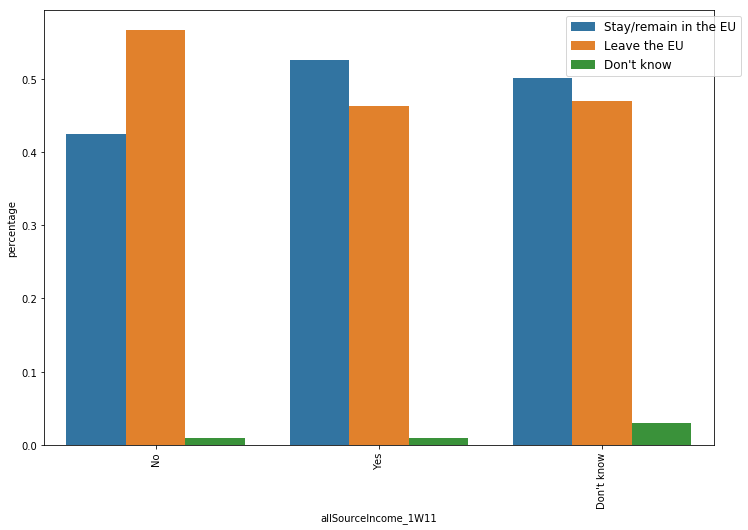

In [59]:
income = "allSourceIncome_1W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_2W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.522210
1,No,Leave the EU,0.468304
2,No,Don't know,0.009486
3,Yes,Stay/remain in the EU,0.407310
4,Yes,Leave the EU,0.585345
5,Yes,Don't know,0.007344
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_2W11,profile_eurefvote,0
0,No,Stay/remain in the EU,9655
1,No,Leave the EU,8118
2,No,Don't know,132
3,Yes,Stay/remain in the EU,4234
4,Yes,Leave the EU,5074
5,Yes,Don't know,54
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


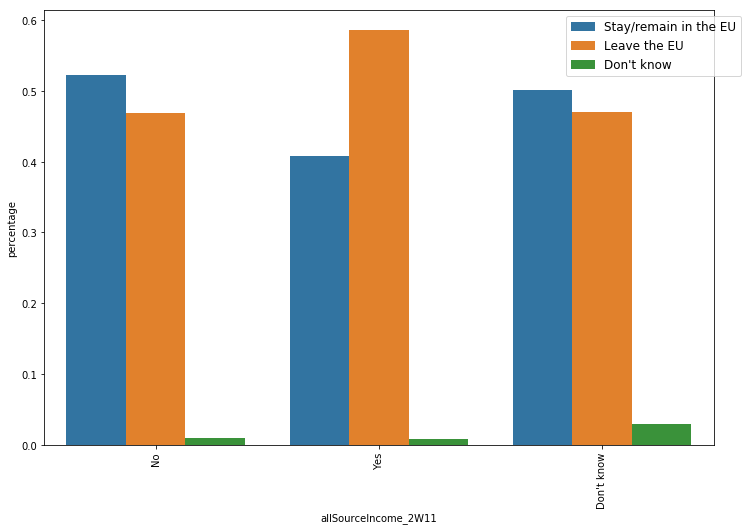

In [60]:
income = "allSourceIncome_2W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_3W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.532042
1,No,Leave the EU,0.458344
2,No,Don't know,0.009614
3,Yes,Stay/remain in the EU,0.376921
4,Yes,Leave the EU,0.616155
5,Yes,Don't know,0.006924
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_3W11,profile_eurefvote,0
0,No,Stay/remain in the EU,10189
1,No,Leave the EU,8032
2,No,Don't know,133
3,Yes,Stay/remain in the EU,3700
4,Yes,Leave the EU,5160
5,Yes,Don't know,53
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


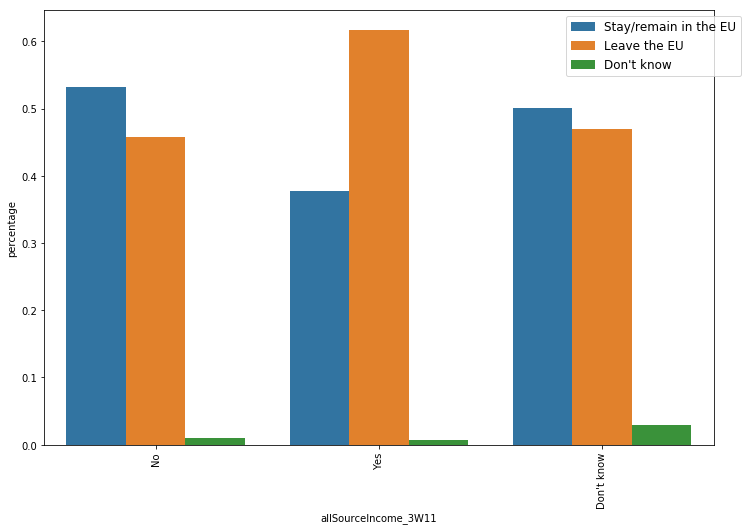

In [61]:
income = "allSourceIncome_3W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_4W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.490584
1,No,Leave the EU,0.500758
2,No,Don't know,0.008658
3,Yes,Stay/remain in the EU,0.445100
4,Yes,Leave the EU,0.535363
5,Yes,Don't know,0.019537
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_4W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13676
1,No,Leave the EU,12938
2,No,Don't know,183
3,Yes,Stay/remain in the EU,213
4,Yes,Leave the EU,254
5,Yes,Don't know,3
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


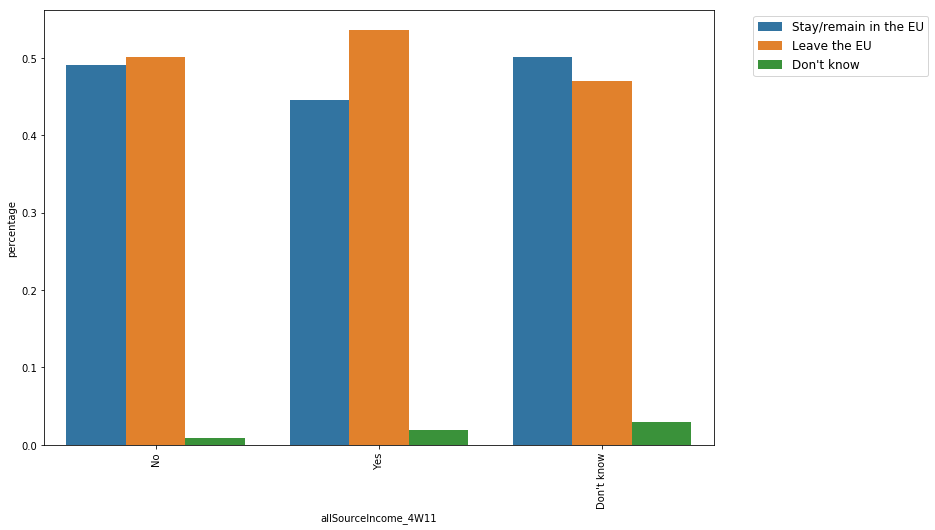

In [62]:
income = "allSourceIncome_4W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_5W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.491679
1,No,Leave the EU,0.499586
2,No,Don't know,0.008735
3,Yes,Stay/remain in the EU,0.422617
4,Yes,Leave the EU,0.563719
5,Yes,Don't know,0.013664
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_5W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13557
1,No,Leave the EU,12762
2,No,Don't know,178
3,Yes,Stay/remain in the EU,332
4,Yes,Leave the EU,430
5,Yes,Don't know,8
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


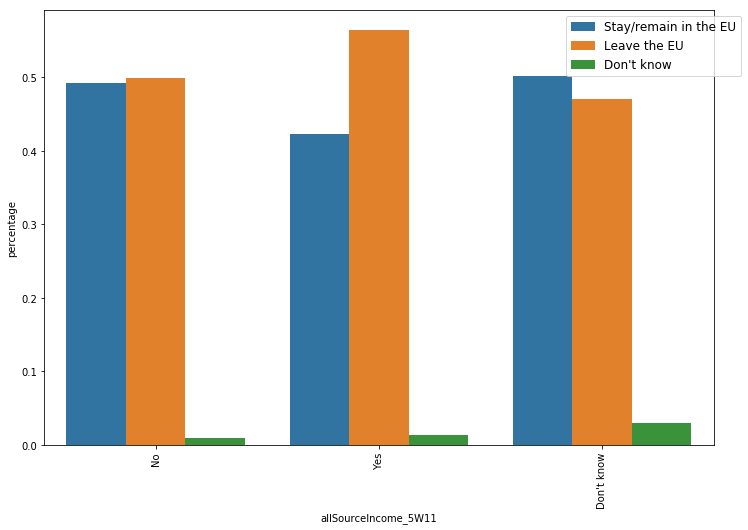

In [63]:
income = "allSourceIncome_5W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_6W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.499377
1,No,Leave the EU,0.491580
2,No,Don't know,0.009044
3,Yes,Stay/remain in the EU,0.382240
4,Yes,Leave the EU,0.610702
5,Yes,Don't know,0.007059
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_6W11,profile_eurefvote,0
0,No,Stay/remain in the EU,12877
1,No,Leave the EU,11708
2,No,Don't know,171
3,Yes,Stay/remain in the EU,1012
4,Yes,Leave the EU,1484
5,Yes,Don't know,15
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


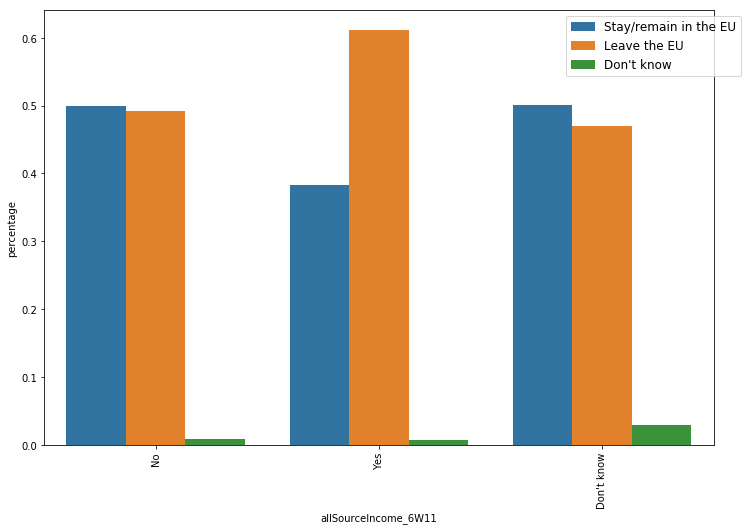

In [65]:
income = "allSourceIncome_6W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_7W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.492266
1,No,Leave the EU,0.498672
2,No,Don't know,0.009062
3,Yes,Stay/remain in the EU,0.440845
4,Yes,Leave the EU,0.553707
5,Yes,Don't know,0.005449
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_7W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13196
1,No,Leave the EU,12411
2,No,Don't know,177
3,Yes,Stay/remain in the EU,693
4,Yes,Leave the EU,781
5,Yes,Don't know,9
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


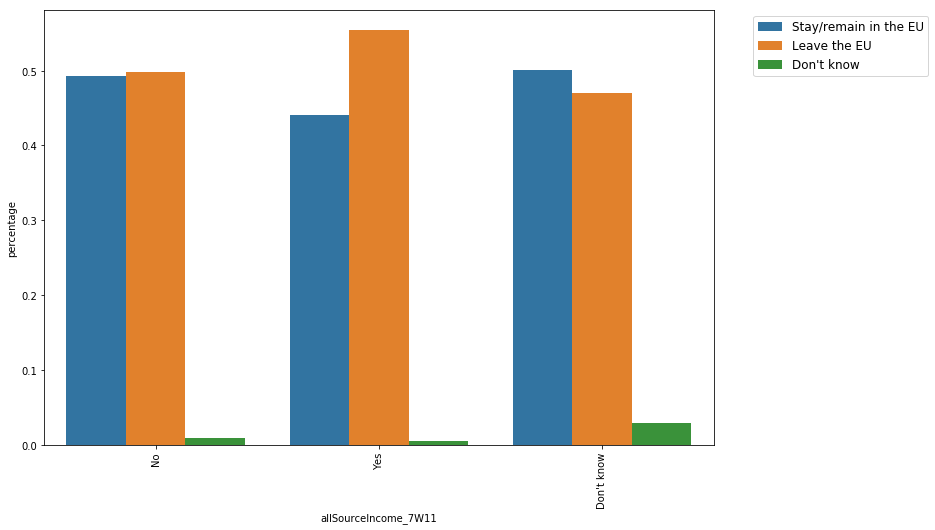

In [66]:
income = "allSourceIncome_7W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_8W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.487286
1,No,Leave the EU,0.503591
2,No,Don't know,0.009123
3,Yes,Stay/remain in the EU,0.502614
4,Yes,Leave the EU,0.489836
5,Yes,Don't know,0.007550
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_8W11,profile_eurefvote,0
0,No,Stay/remain in the EU,11255
1,No,Leave the EU,10836
2,No,Don't know,162
3,Yes,Stay/remain in the EU,2634
4,Yes,Leave the EU,2356
5,Yes,Don't know,24
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


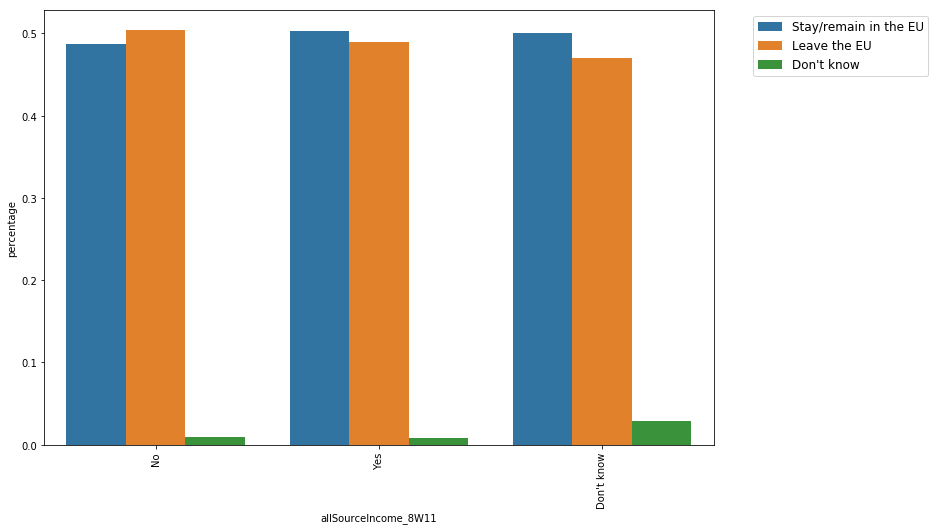

In [67]:
income = "allSourceIncome_8W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_9W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.474575
1,No,Leave the EU,0.516359
2,No,Don't know,0.009067
3,Yes,Stay/remain in the EU,0.799261
4,Yes,Leave the EU,0.195710
5,Yes,Don't know,0.005029
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_9W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13194
1,No,Leave the EU,13041
2,No,Don't know,181
3,Yes,Stay/remain in the EU,695
4,Yes,Leave the EU,151
5,Yes,Don't know,5
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


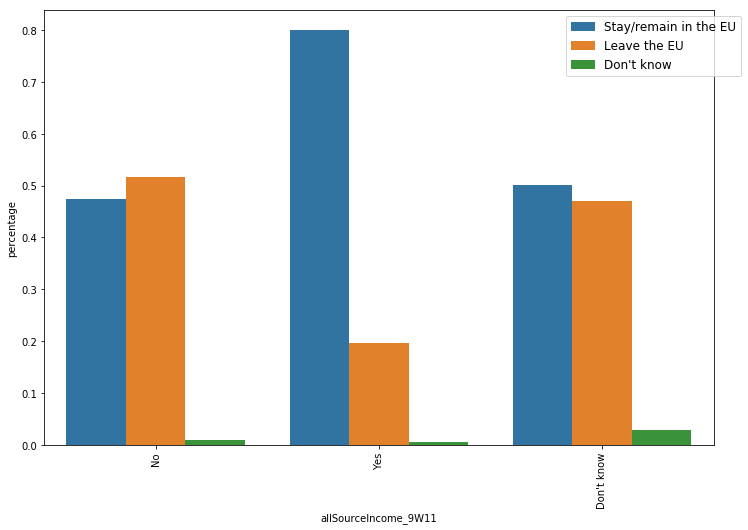

In [68]:
income = "allSourceIncome_9W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_10W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.480203
1,No,Leave the EU,0.510944
2,No,Don't know,0.008853
3,Yes,Stay/remain in the EU,0.760847
4,Yes,Leave the EU,0.229517
5,Yes,Don't know,0.009636
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_10W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13367
1,No,Leave the EU,13040
2,No,Don't know,181
3,Yes,Stay/remain in the EU,522
4,Yes,Leave the EU,152
5,Yes,Don't know,5
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


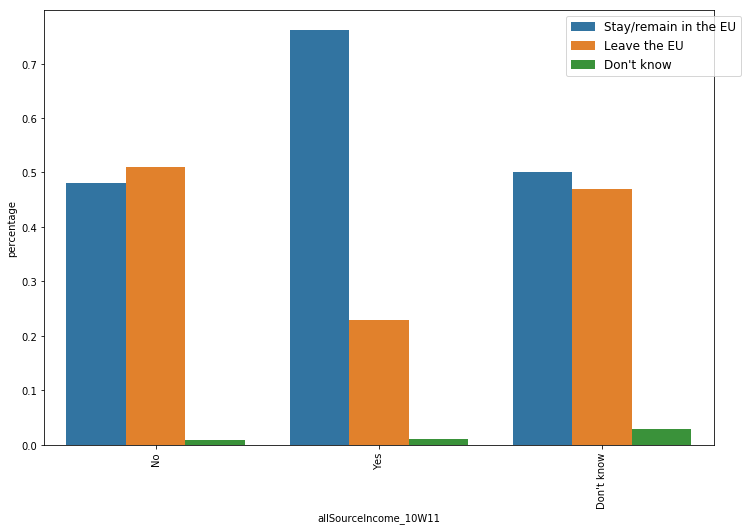

In [69]:
income = "allSourceIncome_10W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_11W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.487106
1,No,Leave the EU,0.504032
2,No,Don't know,0.008862
3,Yes,Stay/remain in the EU,0.542723
4,Yes,Leave the EU,0.448043
5,Yes,Don't know,0.009235
6,Don't know,Stay/remain in the EU,0.501111
7,Don't know,Leave the EU,0.469920
8,Don't know,Don't know,0.028970


,allSourceIncome_11W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13107
1,No,Leave the EU,12565
2,No,Don't know,174
3,Yes,Stay/remain in the EU,782
4,Yes,Leave the EU,627
5,Yes,Don't know,12
6,Don't know,Stay/remain in the EU,511
7,Don't know,Leave the EU,525
8,Don't know,Don't know,31


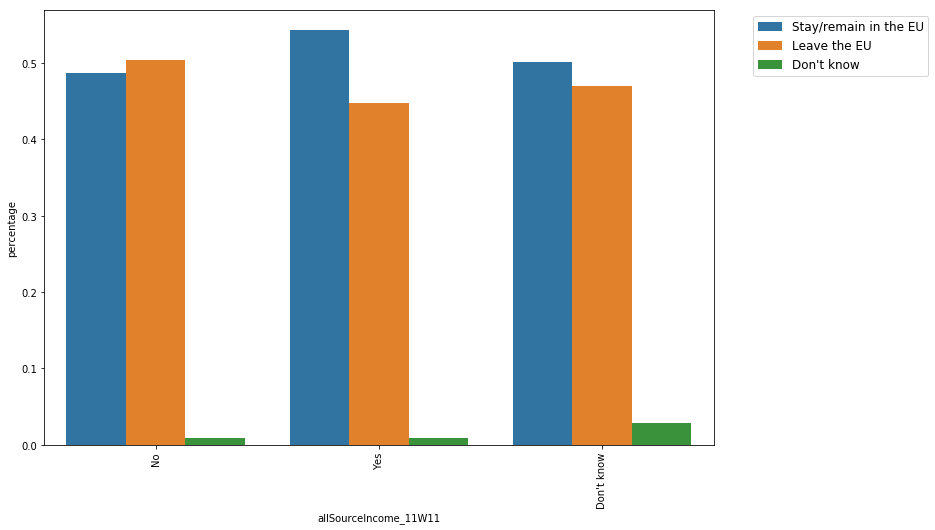

In [71]:
income = "allSourceIncome_11W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);

,allSourceIncome_99W11,profile_eurefvote,percentage
0,No,Stay/remain in the EU,0.489661
1,No,Leave the EU,0.501460
2,No,Don't know,0.008879
3,Yes,Stay/remain in the EU,0.501111
4,Yes,Leave the EU,0.469920
5,Yes,Don't know,0.028970


,allSourceIncome_99W11,profile_eurefvote,0
0,No,Stay/remain in the EU,13889
1,No,Leave the EU,13192
2,No,Don't know,186
3,Yes,Stay/remain in the EU,511
4,Yes,Leave the EU,525
5,Yes,Don't know,31


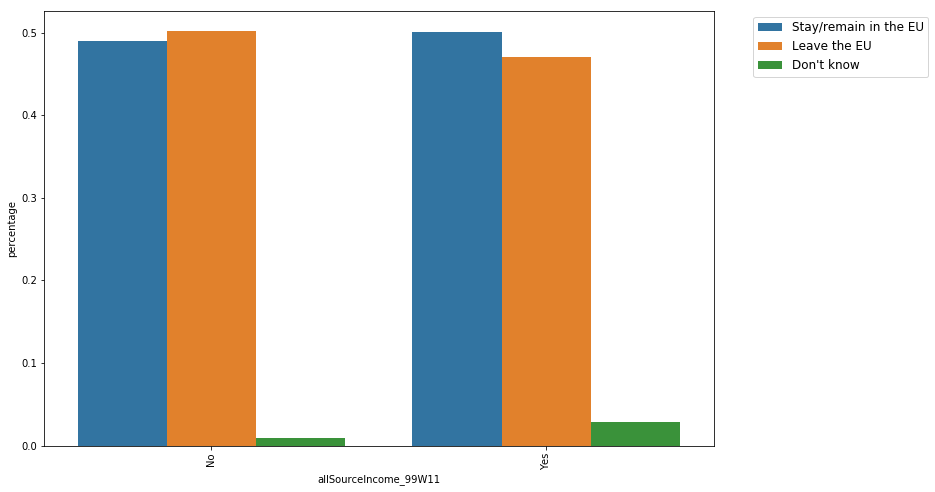

In [72]:
income = "allSourceIncome_99W11"
df = BES_Panel[[income, "profile_eurefvote",'wt_new_W11']]
df = pd.crosstab(index = df[income], columns = df["profile_eurefvote"],
                 values=df['wt_new_W11'], aggfunc='sum', normalize='index').stack().reset_index()
df.columns = [income, 'profile_eurefvote',  'percentage']
display(df)
display(pd.crosstab(index = BES_Panel[income], columns = BES_Panel["profile_eurefvote"]).stack().reset_index())

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=df, x=income, y='percentage', hue='profile_eurefvote')
plt.xticks(rotation=90);

ax.legend(bbox_to_anchor=(1.05, 1.00),ncol=1,fontsize=12);